In [173]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA, KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from matplotlib.colors import ListedColormap
from scipy.spatial.distance import pdist, squareform
from scipy import exp
from scipy.linalg import eigh
from sklearn.datasets import make_moons, make_circles

In [2]:
df_wine = pd.read_csv('datasets/r05/wine.data', header=None)
X_train, X_test, y_train, y_test = \
    train_test_split(df_wine.values[:, 1:], df_wine.values[:, 0],
                     test_size=0.3, stratify=df_wine.values[:, 0],
                     random_state=0)
y_train = y_train.astype('int')
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)

In [3]:
cov_mat = np.cov(X_train_std.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)
print(eigen_vals)

[4.84274532 2.41602459 1.54845825 0.96120438 0.84166161 0.6620634
 0.51828472 0.34650377 0.3131368  0.10754642 0.21357215 0.15362835
 0.1808613 ]


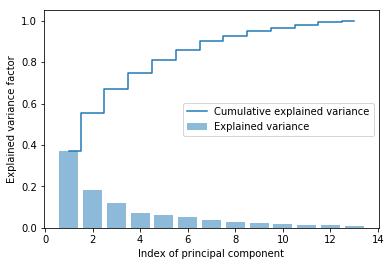

In [4]:
tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
plt.bar(range(1, 14), var_exp, alpha=0.5, align='center',
        label='Explained variance')
plt.step(range(1, 14), cum_var_exp, where='mid',
        label='Cumulative explained variance')
plt.ylabel('Explained variance factor')
plt.xlabel('Index of principal component')
plt.legend(loc='best')
plt.show()

In [5]:
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i])
              for i in range(len(eigen_vals))]
eigen_pairs.sort(key=lambda k: k[0], reverse=True)


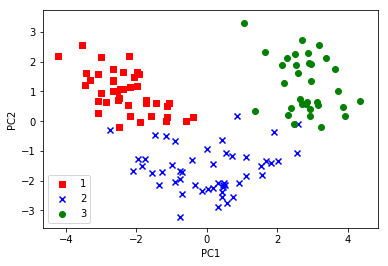

In [6]:
pc1 = eigen_pairs[0][1]
pc2 = eigen_pairs[1][1]
w = np.zeros([13, 2])
w[:, 0] = pc1
w[:, 1] = pc2

X_train_pca = np.dot(X_train_std, w)

colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']
for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train==l, 0],
                X_train_pca[y_train==l, 1],
                color=c, marker=m, label=l)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(loc='lower left')
plt.show()

In [7]:
def plot_decision_regions(X, y, classifier, resolution=0.01):
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim=(xx1.min(), xx1.max())
    plt.ylim=(xx2.min(), xx2.max())
    
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, c=colors[idx],
                    marker=markers[idx], label=cl,
                    edgecolor='black')

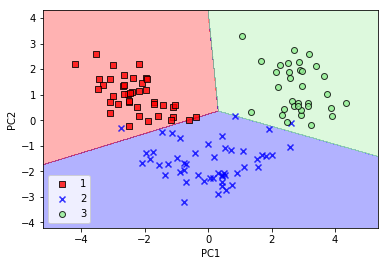

In [8]:
pca = PCA(n_components=2)
lr = LogisticRegression(solver='lbfgs', multi_class='ovr')
pca.fit(X_train_std)
X_train_PCA = pca.transform(X_train_std)
X_test_PCA = pca.transform(X_test_std)
lr.fit(X_train_PCA, y_train)
plot_decision_regions(X_train_PCA, y_train, classifier=lr)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(loc='lower left')
plt.show()

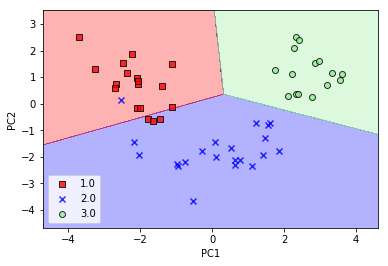

In [9]:
plot_decision_regions(X_test_PCA, y_test, classifier=lr)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(loc='lower left')
plt.show()

In [10]:
pca = PCA(n_components=None)
X_train_PCA = pca.fit_transform(X_train_std)
pca.explained_variance_ratio_

array([0.36951469, 0.18434927, 0.11815159, 0.07334252, 0.06422108,
       0.05051724, 0.03954654, 0.02643918, 0.02389319, 0.01629614,
       0.01380021, 0.01172226, 0.00820609])

In [11]:
np.set_printoptions(precision=4)
mean_vecs = []
for label in range(1, 4):
    mean_vecs.append(np.mean(X_train_std[y_train==label], axis=0))
    print('MV %s:\n %s' %(str(label), mean_vecs[label-1]))

MV 1:
 [ 0.9066 -0.3497  0.3201 -0.7189  0.5056  0.8807  0.9589 -0.5516  0.5416
  0.2338  0.5897  0.6563  1.2075]
MV 2:
 [-0.8749 -0.2848 -0.3735  0.3157 -0.3848 -0.0433  0.0635 -0.0946  0.0703
 -0.8286  0.3144  0.3608 -0.7253]
MV 3:
 [ 0.1992  0.866   0.1682  0.4148 -0.0451 -1.0286 -1.2876  0.8287 -0.7795
  0.9649 -1.209  -1.3622 -0.4013]


In [12]:
d = 13
S_W = np.zeros([d, d])
for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.zeros([d, d])
    for row in X_train_std[y_train==label]:
        row, mv = row.reshape(d, 1), mv.reshape(d, 1)
        class_scatter += (row - mv).dot((row - mv).T)
    S_W += class_scatter
print('S_W shape: %dx%d' % (S_W.shape[0], S_W.shape[1]))
print('Class label distribution: %s' % (np.bincount(y_train)[1:]))

S_W shape: 13x13
Class label distribution: [41 50 33]


In [13]:
d = 13
S_W = np.zeros([d, d])
for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.cov(X_train_std[y_train==label].T)
    S_W += class_scatter
print('S_W shape: %dx%d' % (S_W.shape[0], S_W.shape[1]))

S_W shape: 13x13


In [14]:
mean_overall = np.mean(X_train_std, axis=0)
d = 13
S_B = np.zeros([d, d])
for i, mean_vec in enumerate(mean_vecs):
    n = X_train_std[y_train==label].shape[0]
    mean_vec = mean_vec.reshape(d, 1)
    mean_overall = mean_overall.reshape(d, 1)
    S_B += n * (mean_vec - mean_overall).dot(
               (mean_vec - mean_overall).T)
print('S_B shape: %dx%d' % (S_B.shape[0], S_B.shape[1]))

S_B shape: 13x13


In [15]:
eigen_vals, eigen_vecs = \
    np.linalg.eig(np.linalg.inv(S_W).dot(S_B))
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i])
              for i in range(len(eigen_vals))]
eigen_pairs = sorted(eigen_pairs,
                     key=lambda k: k[0], reverse=True)
print('Own values in descending order:\n')
for eigen_pair in eigen_pairs:
    print(eigen_pair[0])

Own values in descending order:

319.9653240761887
129.1476960381282
2.842170943040401e-14
2.3007339046280886e-14
1.8776532055824114e-14
1.8776532055824114e-14
1.6555779263541983e-14
1.3532952201006142e-14
1.3532952201006142e-14
9.526348619920438e-15
9.526348619920438e-15
7.999872950395984e-15
3.297845209687292e-15


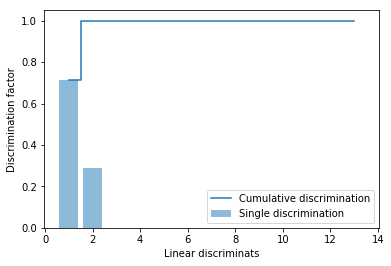

In [16]:
tot = sum(eigen_vals.real)
discr = [(i / tot) for i in sorted(eigen_vals.real, reverse=True)]
cum_discr = np.cumsum(discr)
plt.bar(range(1, 14), sorted(discr, reverse=True), align='center',
        label='Single discrimination', alpha=0.5)
plt.step(range(1, 14), cum_discr, where='mid',
         label='Cumulative discrimination')
plt.xlabel('Linear discriminats')
plt.ylabel('Discrimination factor')
plt.legend(loc='best')
plt.show()

In [17]:
w = np.hstack((eigen_pairs[0][1][:, np.newaxis].real,
              (eigen_pairs[1][1][:, np.newaxis].real)))

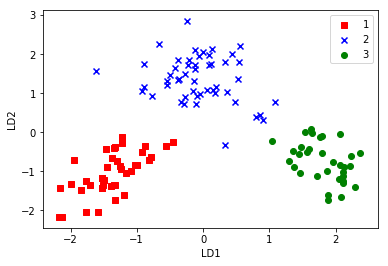

In [18]:
X_train_lda = X_train_std.dot(w)
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']
for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_lda[y_train==l, 0],
                X_train_lda[y_train==l, 1],
                color=c, marker=m, label=l)
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.legend(loc='upper right')
plt.show()

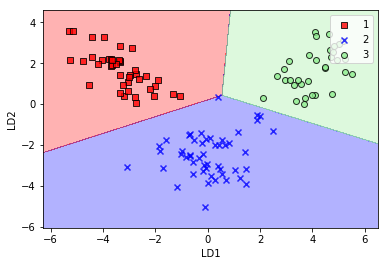

In [19]:
lda = LDA(n_components=2)
X_train_lda = lda.fit_transform(X_train_std, y_train)
lr = LogisticRegression(solver='lbfgs', multi_class='ovr')
lr.fit(X_train_lda, y_train)
plot_decision_regions(X_train_lda, y_train, classifier=lr)
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.legend(loc='upper right')
plt.show()

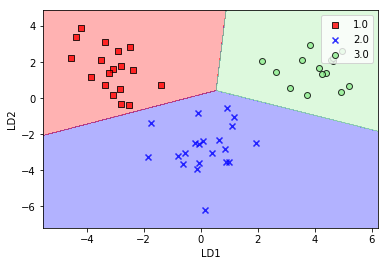

In [20]:
X_test_lda = lda.transform(X_test_std)
plot_decision_regions(X_test_lda, y_test, classifier=lr)
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.legend(loc='upper right')
plt.show()

In [89]:
def rbf_kernel_pca(X, gamma, n_components):
    sq_dist = pdist(X, 'sqeuclidean')
    mat_sq_dists = squareform(sq_dist)
    K = exp(-gamma * mat_sq_dists)
    
    N = K.shape[0]
    one_n = np.ones([N, N]) / N
    K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)
    
    eigvals, eigvecs = eigh(K)
    eigvecs = eigvecs[:, ::-1]
    X_pc = np.column_stack((eigvecs[:, i] for i in range(n_components)))
    
    return X_pc

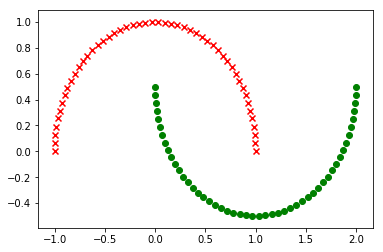

In [47]:
X, y = make_moons(n_samples=100, random_state=123)
plt.scatter(X[y==0, 0], X[y==0, 1], color='r', marker='x')
plt.scatter(X[y==1, 0], X[y==1, 1], color='g', marker='o')
plt.show()

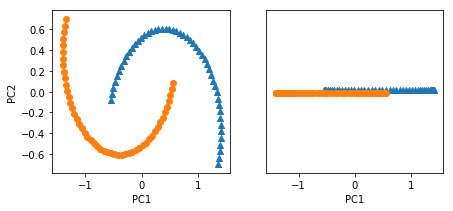

In [70]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].scatter(X_pca[y==0, 0], X_pca[y==0, 1], marker='^')
ax[0].scatter(X_pca[y==1, 0], X_pca[y==1, 1])
ax[1].scatter(X_pca[y==0, 0], np.zeros(50)+0.02, marker='^')
ax[1].scatter(X_pca[y==1, 0], np.zeros(50)-0.02)
ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_xlabel('PC1')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
fig.set_size_inches([7, 3])
plt.show()


C:\Users\Mikolaj\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if sys.path[0] == '':


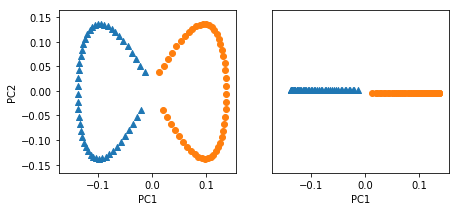

In [105]:
X_pca = rbf_kernel_pca(X, gamma=15, n_components=2)
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].scatter(X_pca[y==0, 0], X_pca[y==0, 1], marker='^')
ax[0].scatter(X_pca[y==1, 0], X_pca[y==1, 1])
ax[1].scatter(X_pca[y==0, 0], np.zeros(50)+0.02, marker='^')
ax[1].scatter(X_pca[y==1, 0], np.zeros(50)-0.02)
ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_xlabel('PC1')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
fig.set_size_inches([7, 3])
plt.show()

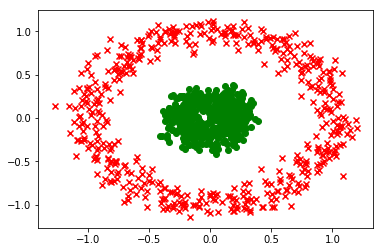

In [118]:
X, y = make_circles(n_samples=1000, random_state=123,
                    noise=0.1, factor=0.2)
plt.scatter(X[y==0, 0], X[y==0, 1], color='r', marker='x')
plt.scatter(X[y==1, 0], X[y==1, 1], color='g', marker='o')
plt.show()

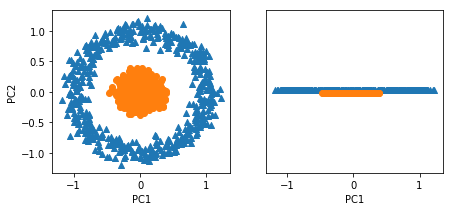

In [130]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].scatter(X_pca[y==0, 0], X_pca[y==0, 1], marker='^')
ax[0].scatter(X_pca[y==1, 0], X_pca[y==1, 1])
ax[1].scatter(X_pca[y==0, 0], np.zeros(500)+0.02, marker='^')
ax[1].scatter(X_pca[y==1, 0], np.zeros(500)-0.02)
ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_xlabel('PC1')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
fig.set_size_inches([7, 3])
plt.show()

C:\Users\Mikolaj\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if sys.path[0] == '':


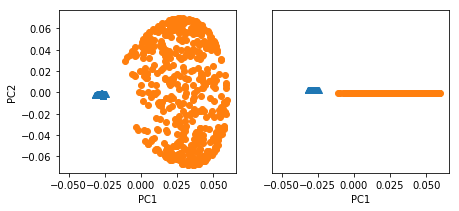

In [134]:
X_pca = rbf_kernel_pca(X, gamma=15, n_components=2)
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].scatter(X_pca[y==0, 0], X_pca[y==0, 1], marker='^')
ax[0].scatter(X_pca[y==1, 0], X_pca[y==1, 1])
ax[1].scatter(X_pca[y==0, 0], np.zeros(500)+0.02, marker='^')
ax[1].scatter(X_pca[y==1, 0], np.zeros(500)-0.02)
ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_xlabel('PC1')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
fig.set_size_inches([7, 3])
plt.show()

In [135]:
def rbf_kernel_pca(X, gamma, n_components):
    sq_dist = pdist(X, 'sqeuclidean')
    mat_sq_dists = squareform(sq_dist)
    K = exp(-gamma * mat_sq_dists)
    
    N = K.shape[0]
    one_n = np.ones([N, N]) / N
    K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)
    
    eigvals, eigvecs = eigh(K)
    eigvals, eigvecs = eigvals[::-1], eigvecs[:, ::-1]
    
    alphas = np.column_stack((eigvecs[:, i] for i in range(n_components)))
    lambdas = [eigvals[i] for i in range(n_components)]
    
    return alphas, lambdas

In [145]:
X, y = make_moons(n_samples=100, random_state=123)
alphas, lambdas = rbf_kernel_pca(X, gamma=15, n_components=1)

C:\Users\Mikolaj\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  del sys.path[0]


In [155]:
x_new = X[25]
print(x_new)
x_proj = alphas[25]
print(x_proj)

def project_x(x_new, X, gamma, alphas, lambdas):
    pair_dist = [np.sum((x_new-row)**2) for row in X]
    pair_dist = np.array(pair_dist)
    k = np.exp(-gamma * pair_dist)
    return k.dot(alphas / lambdas)

x_reproj = project_x(x_new, X, gamma=15,
                     lambdas=lambdas, alphas=alphas)

print(x_reproj)

[1.8713 0.0093]
[0.0788]
[0.0788]


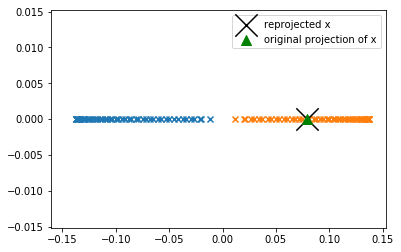

In [172]:
plt.scatter(alphas[y==0, 0], np.zeros(50), marker='x')
plt.scatter(alphas[y==1, 0], np.zeros(50), marker='x')
plt.scatter(x_reproj, 0, marker='x', color='black', s=500,
            label='reprojected x')
plt.scatter(x_proj, 0, marker='^', color='green', s=100,
            label='original projection of x')
plt.legend()
plt.show()

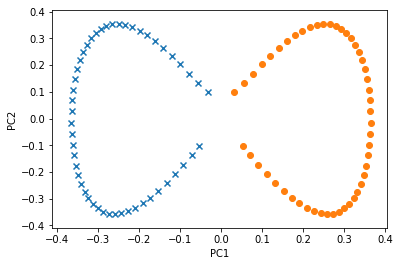

In [179]:
X, y = make_moons(n_samples=100, random_state=123)
kpca = KernelPCA(n_components=2, gamma=15, kernel='rbf')
X_kpca = kpca.fit_transform(X)

plt.scatter(X_kpca[y==0, 0], X_kpca[y==0, 1], marker='x')
plt.scatter(X_kpca[y==1, 0], X_kpca[y==1, 1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()